In [1]:
import random_VQE_data_prep as ran_VQE
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold 
import os
import pickle
import re

import FeatureExtract as FE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder
from qiskit_aer import Aer
from qiskit_ibm_runtime.fake_provider import FakeQuitoV2

from folded_circuit import data_storage_Folded_circuit


Split the generated data into an validation and train/test set. `train_frac` can be chosen and decides how many percent of the data are used to train and test the model.

In [2]:
def split_data(path="./scaled_pickles", train_frac = 0.8):
    ### split data into evaluation and training set
    assert train_frac < 1
    assert train_frac >= 0

    # shuffle data randomly to make different datasets
    all_files = os.listdir(path)
    # data_size = data.shape[0] # data.shape[0] changed to fit dictionary
    # indices = np.arange(data_size)  
    np.random.shuffle(all_files)
    #data_shuffled = data[indices]

    # split shuffeled data into test, train and eval according to fractions
    idx_eval = int(train_frac * len(all_files))

    files_train = all_files[:idx_eval]
    files_eval = all_files[idx_eval:]

    return files_train, files_eval

files_train_scal, files_eval_scal = split_data()

files_train, files_eval = split_data('./pickles')

files_train_scal[0], files_train[0]

('circ_402_scaled.pickle', 'circ_34.pickle')

`file_to_data(files)` takes a list of circuits and generates the data using `extract_features(path)`

In [3]:
def file_to_data(files):
    a = list()
    for i, idx in enumerate(files):
        a.append(FE.extract_features(f"./pickles/{idx}"))
    df = pd.DataFrame(a)
    return df

def file_to_data_scaled(files):
    a = list()
    for i, idx in enumerate(files):
        a.append(FE.extract_features_scaled(f"./scaled_pickles/{idx}"))
    df = pd.DataFrame(a)
    return df

df_eval = file_to_data(files_eval)
df_train = file_to_data(files_train)
df_eval_scaled = file_to_data_scaled(files_train_scal)
df_train_scaled = file_to_data_scaled(files_train_scal)

df_eval = pd.concat([df_eval, df_eval_scaled])
df_train = pd.concat([df_train, df_train_scaled])

In [4]:
df_train

,noisy_expectation,num_layers,tot_num_gates,num_cx_gates,num_sx_gates,num_2_qubit_gates,obs_dummy_1,obs_dummy_2,obs_dummy_3,obs_dummy_4,obs_dummy_5,"count_['1', '3']","count_['1', '2']","count_['0', '1']","count_['3', '4']",target
0,0.11986,4,171,32,46,32,0,0,0,1,0,8,8,8,8,0.352924
1,0.01232,5,207,40,56,40,0,1,0,0,0,10,10,10,10,-0.410284
2,0.08688,3,134,24,36,24,0,1,0,0,0,6,6,6,6,-0.032078
3,0.47570,1,59,8,16,8,0,0,1,0,0,2,2,2,2,0.455825
4,-0.41264,2,94,16,25,16,0,0,1,0,0,4,4,4,4,-0.976371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.09336,4,227,46,52,46,0,0,1,0,0,12,10,14,10,-0.292581
796,0.08450,1,96,12,21,12,0,0,1,0,0,2,2,4,4,-0.139371
797,0.03616,4,285,48,65,48,1,0,0,0,0,12,10,16,10,0.320453
798,0.01508,2,156,24,34,24,0,0,1,0,0,6,4,8,6,-0.284101


`split_data_kfold(df_train)` returns all the training and test data, as features (X) and the value to predict (y)

In [14]:
def split_data_kfold(df_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    X = df_train.drop(columns=['target'])
    y = df_train['target']
    
    for train_index, test_index in kf.split(df_train):
        X_train.append(X.iloc[train_index])
        X_test.append(X.iloc[test_index])
        y_train.append(y.iloc[train_index])
        y_test.append(y.iloc[test_index])
        
    return X_train, X_test, y_train, y_test

# Ensure the data is correct and check the type of first element
X_train, X_test, y_train, y_test = split_data_kfold(df_train)
#print(X_train)

`Linear_Reg(data)` returns the best model of the k = 5 splits according to the R2

In [15]:
def Linear_Reg():
    # returns best fitting linear model of all trained models based on MSE
    # X_train, y_train, X_test, y_test are numpy arrays
    # returns best model, MSE, R2
    #X_train, X_test, y_train, y_test = split_data_kfold(df_train)

    best_model = None
    best_model_MSE = float('inf')
    best_model_R2 = float('-inf')
    
    for i in range(len(X_train)):
        if X_train[i].empty or y_train[i].empty:
            print(f"Skipping fold {i} due to empty training data.")
            continue       
        
        model = LinearRegression()
        model.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])

        MSE = mean_squared_error(y_test[i], y_pred)
        R2 = r2_score(y_test[i], y_pred)

        print(f'Fold {i} - MSE: {MSE:.4f}, R2: {R2:.4f}')
        
        if R2 > best_model_R2:
            best_model = model
            best_model_MSE = MSE
            best_model_R2 = R2
    return best_model, best_model_MSE, best_model_R2

best_model_lin, MSE, R2 = Linear_Reg()
print (f'MSE: {MSE}; R2: {R2}')

Fold 0 - MSE: 0.0599, R2: 0.6177
Fold 1 - MSE: 0.0614, R2: 0.6420
Fold 2 - MSE: 0.0667, R2: 0.5733
Fold 3 - MSE: 0.0532, R2: 0.6737
Fold 4 - MSE: 0.0711, R2: 0.5412
MSE: 0.05318974060828171; R2: 0.6737475564700564


In [16]:
from sklearn.preprocessing import PolynomialFeatures

def Lin_Reg_Interaction():
    # Linear Regression with Interaction Terms
    poly = PolynomialFeatures(interaction_only=True,include_bias = False)
    X_poly = poly.fit_transform(df_train.drop(columns=['target']))

    lri = LinearRegression()
    lri.fit(X_poly, df_train['target'])

    y_eval = df_eval['target']

    X_poly_eval = poly.fit_transform(df_eval.drop(columns=['target']))
    y_pred_lri = lri.predict(X_poly_eval)
    MSE_lri = mean_squared_error(y_eval, y_pred_lri)
    R2_lri = r2_score(y_eval, y_pred_lri)

    #print(lri.coef_)

    return MSE_lri, R2_lri

MSE_lri_1, R2_lri = Lin_Reg_Interaction()

In [17]:
from sklearn.feature_selection import f_regression

poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(df_train.drop(columns=['target']))

f_stat, p_val = f_regression(X_poly, df_train['target'])

df = pd.DataFrame({'Feature': pd.DataFrame(X_poly).columns, 'F-statistic': f_stat, 'p-value': p_val})
df_large_p = df[df['p-value'] > 0.05]
#display(df_large_p)

features_to_remove = df_large_p['Feature'].tolist()

# Remove these features from df_train
df_train_reduced_no_out = pd.DataFrame(X_poly).drop(columns=features_to_remove)
#df_train_reduced_no_out

In [18]:
lri = LinearRegression()
lri.fit(df_train_reduced_no_out, df_train['target'])

X_poly_eval = poly.fit_transform(df_eval.drop(columns=['target']))
X_poly_eval = pd.DataFrame(X_poly_eval).drop(columns=features_to_remove)
y_pred_lri = lri.predict(X_poly_eval)
MSE_lri_2 = mean_squared_error(df_eval['target'], y_pred_lri)
MSE_lri_2

0.07048865341187073

In [19]:
X_eval = df_eval.drop(columns=['target']).reindex(columns=X_train[0].columns)
y_eval = df_eval['target']

y_pred_eval_lin_reg = best_model_lin.predict(X_eval)

MSE_lin_reg = mean_squared_error(y_eval, y_pred_eval_lin_reg)
R2_lin_reg = r2_score(y_eval, y_pred_eval_lin_reg)

print(f'Evaluation of best model - MSE: {MSE_lin_reg:.4f}, R2: {R2_lin_reg:.4f}')
print(best_model_lin.coef_)
print(best_model_lin.intercept_)


Evaluation of best model - MSE: 0.0680, R2: 0.5887
[ 1.27326495e+00 -3.83242930e-02 -1.19144339e-03  3.23901544e-04
  7.30346775e-03  3.23901544e-04  6.81691285e-02  6.26995034e-02
 -1.50371544e-01 -2.31417487e-02  4.26446608e-02 -5.32181123e-04
 -1.22098834e-03 -2.97502014e-03  5.05209115e-03]
-0.09857722836231496


In [20]:
#print(y_eval[:10], y_pred_eval[:10])

Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

max_depth = [int(x) for x in np.linspace(1, 25, num = 5)]
max_depth.append(None)
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 110, num = 5)]

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': max_depth,
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 4, 8],
    'n_estimators': n_estimators,
    'criterion': ['squared_error', 'absolute_error']
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                        cv = 3, n_jobs = -1, verbose = 2, n_iter=75, random_state=42)


In [22]:
random_search.fit(df_train.drop(columns='target'), df_train['target'])
y_pred = random_search.predict(X_eval)

MSE_rf_hyperparam = mean_squared_error(y_eval, y_pred)
R2_rf_hyperparam = r2_score(y_eval, y_pred)

print(f'Evaluation of best model - MSE: {MSE_rf_hyperparam:.4f}, R2: {R2_rf_hyperparam:.4f}')

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Evaluation of best model - MSE: 0.0522, R2: 0.6845


In [23]:
random_search.best_params_

{'n_estimators': 85,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 7,
 'criterion': 'absolute_error',
 'bootstrap': True}

{'n_estimators': 85,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 19,
 'criterion': 'absolute_error',
 'bootstrap': True}

In [24]:
from sklearn.ensemble import RandomForestRegressor


def Random_Forest():
    # returns best fitting linear model of all trained models based on MSE
    # X_train, y_train, X_test, y_test are numpy arrays
    # returns best model, MSE, R2
    best_model = None
    best_model_MSE = float('inf')
    best_model_R2 = float('-inf')
    
    for i in range(len(X_train)): 

        rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=5)
        rf.fit(X_train[i], y_train[i])
        y_pred = rf.predict(X_test[i])

        MSE = mean_squared_error(y_test[i], y_pred)
        R2 = r2_score(y_test[i], y_pred)

        print(f'Fold {i} - MSE: {MSE:.4f}, R2: {R2:.4f}')
        
        if R2 > best_model_R2:
            best_model = rf
            best_model_MSE = MSE
            best_model_R2 = R2
    return best_model, best_model_MSE, best_model_R2

best_model_rf, MSE, R2 = Random_Forest()
print (f'MSE: {MSE}; R2: {R2}')

y_pred_eval_rf = best_model_rf.predict(X_eval)

MSE_rf = mean_squared_error(y_eval, y_pred_eval_rf)
R2_rf = r2_score(y_eval, y_pred_eval_rf)

print(f'Evaluation of best model - MSE: {MSE_rf:.4f}, R2: {R2_rf:.4f}')

Fold 0 - MSE: 0.0575, R2: 0.6331
Fold 1 - MSE: 0.0631, R2: 0.6321
Fold 2 - MSE: 0.0604, R2: 0.6134
Fold 3 - MSE: 0.0520, R2: 0.6812
Fold 4 - MSE: 0.0680, R2: 0.5613
MSE: 0.05197510377637602; R2: 0.6811978322164471
Evaluation of best model - MSE: 0.0569, R2: 0.6560


In [28]:
# Random forest trained on scaled circuits only

rf_scaled = RandomForestRegressor()

rf_scaled.fit(df_train_scaled.drop(columns='target'), df_train_scaled['target'])

y_pred_eval_rf_scaled = rf_scaled.predict(df_eval_scaled.drop(columns='target'))

MSE_rf_scaled = mean_squared_error(df_eval_scaled['target'], y_pred_eval_rf_scaled)
R2_rf_scaled = r2_score(df_eval_scaled['target'], y_pred_eval_rf_scaled)

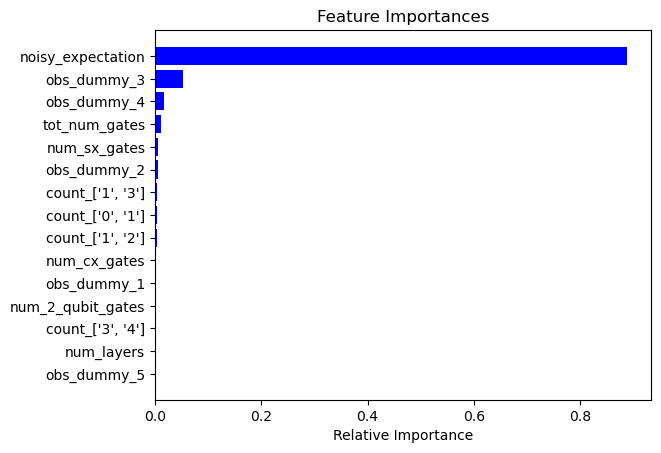

In [29]:
import matplotlib.pyplot as plt

features = X_train[0].columns
importances = best_model_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### plot of RFR only trained on `noisy_expectation`

c:\Users\malte\anaconda3\envs\Projectsem\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


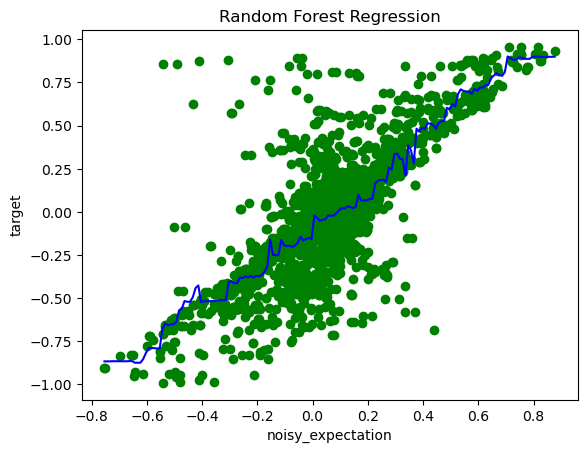

In [30]:
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=5)
rf.fit(pd.DataFrame(df_train['noisy_expectation']), df_train['target'])

X_grid = np.arange(min(df_train['noisy_expectation']), max(df_train['noisy_expectation']), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(df_train['noisy_expectation'], df_train['target'], color = 'green')
plt.plot(X_grid, rf.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.xlabel('noisy_expectation')
plt.ylabel('target')
plt.show()

# Plot errors

Text(0.5, 1.0, 'Correlation Matrix')

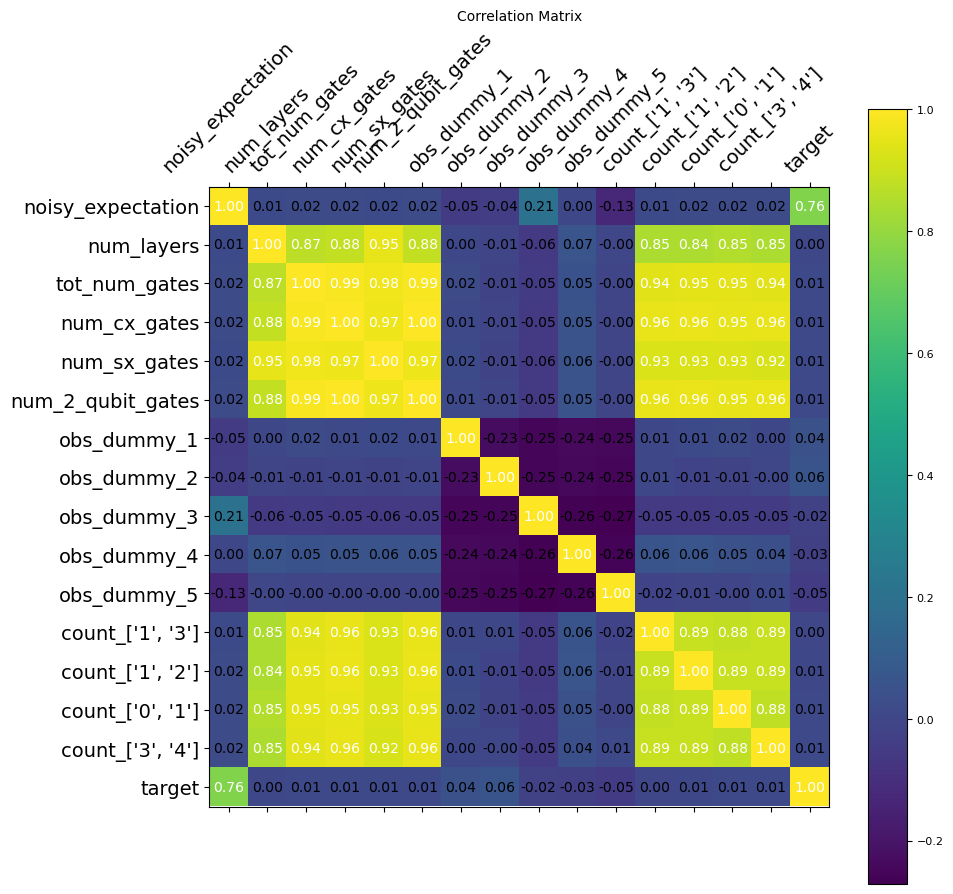

In [31]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(10, 10))
plt.matshow(df_train.corr(), fignum=f.number)
for (i, j), val in np.ndenumerate(df_train.corr().values):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')
plt.xticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=10)

In [32]:
MSE_unmit = mean_squared_error(y_eval, df_eval['noisy_expectation'])
R2_unmit = r2_score(y_eval, df_eval['noisy_expectation'])
MSE_unmit

0.08457583599871978

C:\Users\malte\AppData\Local\Temp\ipykernel_25560\1992000382.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=90, ha='center')


Text(0.5, 1.0, 'MSE values of models folded')

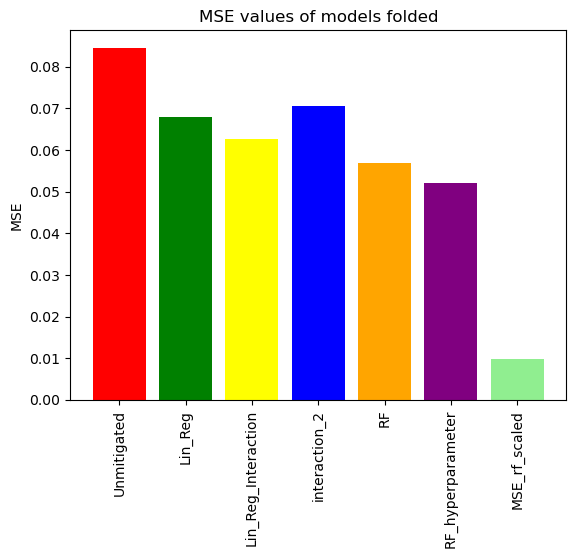

In [33]:
fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'Lin_Reg_Interaction' , 'interaction_2', 'RF', 'RF_hyperparameter', 'MSE_rf_scaled']#, 'RF_hyp_kfold']
MSE_error =[MSE_unmit, MSE_lin_reg, MSE_lri_1, MSE_lri_2, MSE_rf, MSE_rf_hyperparam, MSE_rf_scaled]#, MSE_rf_hyp_kfold]
colors = ['red', 'green', 'yellow', 'blue', 'orange', 'purple', 'lightgreen']

ax.bar(models, MSE_error, color = colors)
ax.set_xticklabels(models, rotation=90, ha='center')
ax.set_ylabel('MSE')
ax.set_title('MSE values of models folded')

C:\Users\malte\AppData\Local\Temp\ipykernel_25560\3508687824.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=90, ha='center')


Text(0.5, 1.0, 'R2 values of models folded')

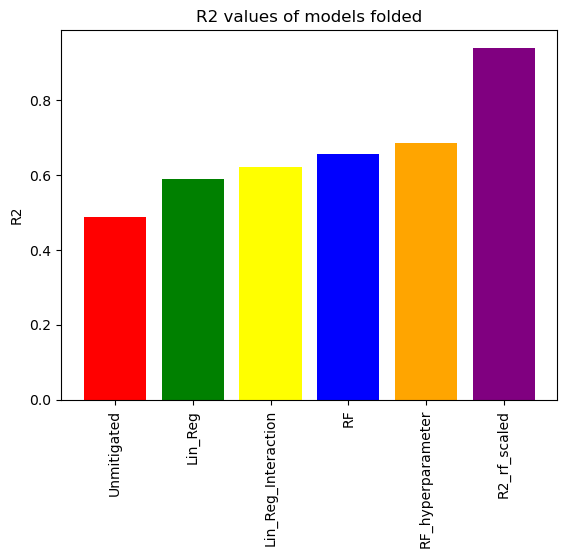

In [35]:
fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'Lin_Reg_Interaction', 'RF', 'RF_hyperparameter', 'R2_rf_scaled']#, 'RF_hyp_kfold']
R2_error =[R2_unmit, R2_lin_reg, R2_lri, R2_rf, R2_rf_hyperparam, R2_rf_scaled]#, R2_rf_hyp_kfold]

ax.bar(models, R2_error, color = colors)
ax.set_xticklabels(models, rotation=90, ha='center')
ax.set_ylabel('R2')
ax.set_title('R2 values of models folded')